In [18]:
%config Completer.use_jedi = False

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
import hydrobr
import geobr
import geopandas as gpd
from datetime import datetime

In [20]:
# Caminhos dos diretórios raiz
# general_path = 'C:/Users/cnalm/OneDrive/Hidroweb'
# general_path = 'D:/Dados_Nuvem/OneDrive/Hidroweb'
general_path = r'C:\Users\linde\OneDrive\Hidroweb'

In [21]:
def correlation_coefficient_pearson(observed_pr, estimated_pr):
    correlation_matrix = np.corrcoef(observed_pr, estimated_pr)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient

In [22]:
def bias(observed_pr, estimated_pr):
    return np.mean(np.array(estimated_pr) - np.array(observed_pr))

In [23]:
def compound_relative_error(observed_pr, estimated_pr):
    numerator = np.sum((np.array(estimated_pr) - np.array(observed_pr))**2)
    avg_actual = np.mean(observed_pr)
    denominator = np.sum((np.array(observed_pr) - avg_actual)**2)
    cre = (numerator / denominator)
    return cre

In [24]:
def mean_absolute_error(observed_pr, estimated_pr):
    absolute_errors = np.abs(np.array(estimated_pr) - np.array(observed_pr))
    mae = np.mean(absolute_errors)
    return mae

In [25]:
def rmse(observed_pr, estimated_pr):
    return np.sqrt(np.mean((np.array(estimated_pr) - np.array(observed_pr))**2))

In [26]:
def factorCalculate(df):
    a = df['Factor_A'].sum()
    b = df['Factor_B'].sum()
    c = df['Factor_C'].sum()
    d = df['Factor_D'].sum()
    return a, b, c, d

In [27]:
def csiCalculate(a, b, c):
    return a / (a + b + c)

In [28]:
def pcCalculate(a, b, c, d):
    return (a + d) / (a + b + c + d)

In [29]:
df = pd.read_hdf(general_path + '/Consolidated Files/BRASIL_INTERPOLATED_VALUES_CONSOLIDATION_1961_2020_REDUCED_V2.h5')
df

,Date,Code,Value,Value_Interpolated
0,1961-01-01,00048000,0.0,0.000000
1,1961-01-01,00062000,0.0,0.000000
2,1961-01-01,00067000,0.0,0.012906
3,1961-01-01,00145004,0.0,0.000000
4,1961-01-01,00148001,0.0,0.000000
...,...,...,...,...
101961834,2020-12-31,03151003,0.0,0.142185
101961835,2020-12-31,03155001,9.8,10.057924
101961836,2020-12-31,03252008,0.0,0.372164
101961837,2020-12-31,03252025,0.5,0.368261


In [30]:
# Initialize a new column 'Wet_Days' with zeros
df['Wet_Days'] = False
df['Wet_Days_Interpolated'] = False

# Calculate 'Wet_Days' every time 'Value' is greater than 0.5
df.loc[df['Value'] >= 0.5, 'Wet_Days'] = True
df.loc[df['Value_Interpolated'] >= 0.5, 'Wet_Days_Interpolated'] = True

df['Factor_A'] = 0
df.loc[((df['Wet_Days'] == True) & (df['Wet_Days_Interpolated'] == True)), 'Factor_A'] = 1

df['Factor_B'] = 0
df.loc[((df['Wet_Days'] == False) & (df['Wet_Days_Interpolated'] == True)), 'Factor_B'] = 1

df['Factor_C'] = 0
df.loc[((df['Wet_Days'] == True) & (df['Wet_Days_Interpolated'] == False)), 'Factor_C'] = 1

df['Factor_D'] = 0
df.loc[((df['Wet_Days'] == False) & (df['Wet_Days_Interpolated'] == False)), 'Factor_D'] = 1

# Daily Parameters

In [91]:
def createHist2D(df_date, date, label_fig = ""):
    plt.rcParams['font.size'] = '14'
    plt.rcParams["font.family"] = "Times New Roman"
    # tnr_title = {'fontname':'Times New Roman', "fontweight" :"bold", 'fontsize': 16}
    # max_value = round(max(max(observed_pr), max(estimated_pr))/10, 0)*10
    max_value = 200
    len_df = len(df_date)
    fig, ax = plt.subplots(figsize=(4.5, 4))
    h = ax.hist2d(observed_pr, estimated_pr, bins=(25, 25), norm=colors.LogNorm(vmin=1, vmax=len_df/25))
    ax.set_xlim(0, max_value)
    ax.set_ylim(0, max_value)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k')
    cbar = plt.colorbar(h[3], ax=ax)
    ax.set_title(str(date.date()))
    ax.set_xlabel('Observed precipitation [mm]')
    ax.set_ylabel('Estimated precipitation [mm]')
    a = max_value/15.0
    hor = max_value/35.0
    x_limit_list = [max_value-a, max_value-a*2.0, max_value-a*3.0, max_value-a*4.0, max_value-a*5.0, max_value-a*6.0, max_value-a*7.0, max_value-a*8.0]
    plt.text(hor, x_limit_list[0], f'n = {len_df:.0f}')
    plt.text(hor, x_limit_list[1], f'R = {correlation_coefficient:.3f}')
    plt.text(hor, x_limit_list[2], f'Bias = {bias:.3f}')
    plt.text(hor, x_limit_list[3], f'RMSE = {rmse:.3f}')
    plt.text(hor, x_limit_list[4], f"CRE = {cre:.3f}")
    plt.text(hor, x_limit_list[5], f"MAE = {mae:.3f}")
    plt.text(hor, x_limit_list[6], f"PC = {pc:.3f}")
    plt.text(hor, x_limit_list[7], f"CSI = {csi:.3f}")
    plt.text(-40, max_value*1.035, "("+label_fig+")")
    plt.tight_layout(pad = -0.005)
    plt.savefig(general_path +'/Figures/cross_validation_scatter_'+str(date.date())+'_2dhist.jpeg', format='jpeg', dpi=1200, transparent=False, bbox_inches=None)
    plt.show()
    plt.close()

In [68]:
date_list = pd.date_range(start='01-01-1961', end='01-01-2020', freq='10AS')
date_list

DatetimeIndex(['1961-01-01', '1971-01-01', '1981-01-01', '1991-01-01',
               '2001-01-01', '2011-01-01'],
              dtype='datetime64[ns]', freq='10AS-JAN')

1961-01-01


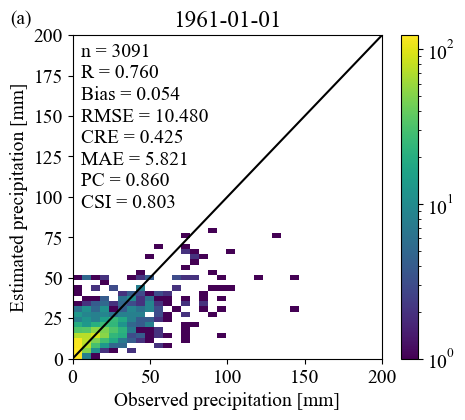

1971-01-01


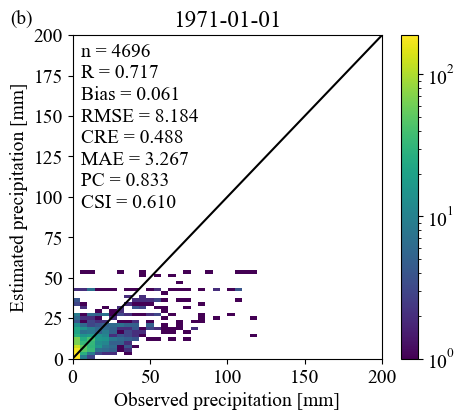

1981-01-01


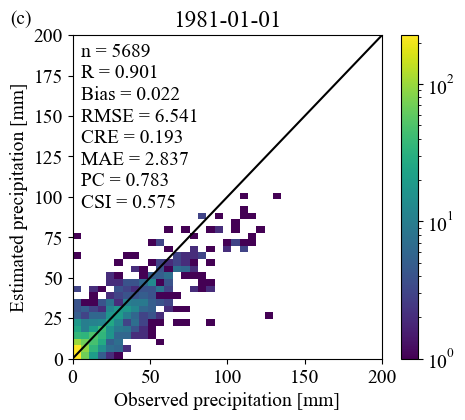

1991-01-01


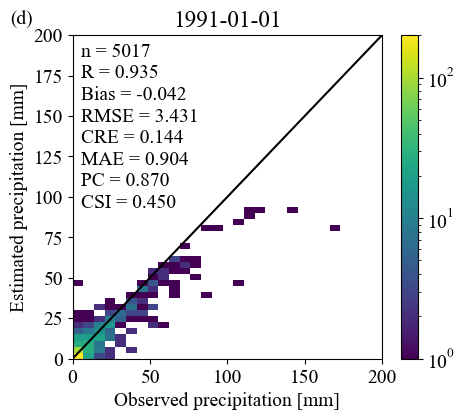

2001-01-01


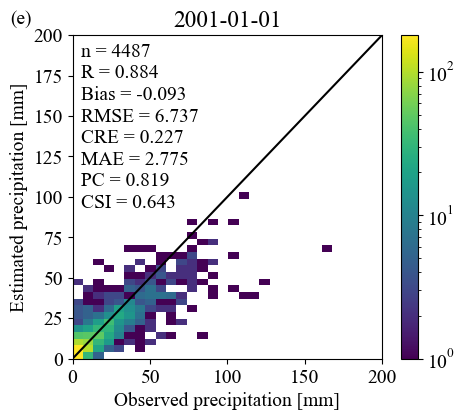

2011-01-01


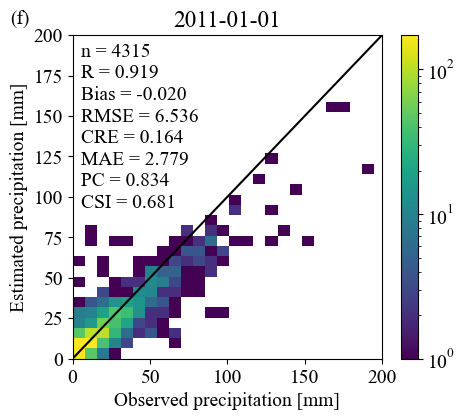

In [92]:
count = 0
label_fig_list = ['a', 'b', 'c', 'd', 'e', 'f'] 
for date in date_list:
    label_fig = label_fig_list[count]
    count = count + 1
    df_date = df[df['Date'] == date]
    a, b, c, d = factorCalculate(df_date)
    csi = csiCalculate(a, b, c)
    pc = pcCalculate(a, b, c, d)
    observed_pr = df_date['Value'].values.tolist()
    estimated_pr = df_date['Value_Interpolated'].values.tolist()
    correlation_coefficient = np.corrcoef(observed_pr, estimated_pr)[0, 1]
    bias = np.mean(np.array(estimated_pr) - np.array(observed_pr))
    rmse = np.sqrt(np.mean((np.array(estimated_pr) - np.array(observed_pr))**2))
    cre = compound_relative_error(observed_pr, estimated_pr)
    mae = mean_absolute_error(observed_pr, estimated_pr)
    print(str(date.date()))
    createHist2D(df_date, date, label_fig)


# DRAFT

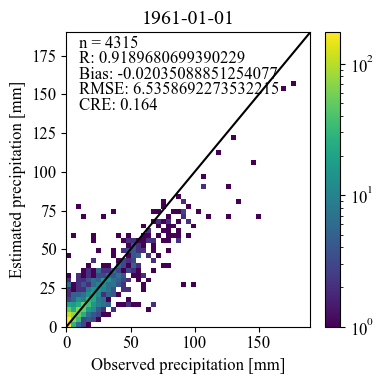

TypeError: bad operand type for unary +: 'str'

In [70]:
plt.rcParams['font.size'] = '12'
plt.rcParams["font.family"] = "Times New Roman"
tnr_title = {'fontname':'Times New Roman', "fontweight" :"bold", 'fontsize': 16}

max_value = round(max(max(observed_pr), max(estimated_pr))/10, 0)*10
len_df = len(df_date)

fig, ax = plt.subplots(figsize=(4, 4))
h = ax.hist2d(observed_pr, estimated_pr, bins=(50, 50), norm=colors.LogNorm(vmin=1, vmax=len_df/25))
ax.set_xlim(0, max_value)
ax.set_ylim(0, max_value)
ax.plot(ax.get_xlim(), ax.get_xlim(), color='k')
cbar = plt.colorbar(h[3], ax=ax)
ax.set_title('1961-01-01')
ax.set_xlabel('Observed precipitation [mm]')
ax.set_ylabel('Estimated precipitation [mm]')

# Add text to the plot
a = max_value
x_limit_list = [a -10, a-20, a-30, a-40, a-50, a-60]
plt.text(10, x_limit_list[0], 'n = ' + str(len_df))
plt.text(10, x_limit_list[1], 'R: ' + str(correlation_coefficient))
plt.text(10, x_limit_list[2], 'Bias: ' + str(bias))
plt.text(10, x_limit_list[3], 'RMSE: ' + str(rmse))
plt.text(10, x_limit_list[4], f"CRE: {cre:.3f}")

plt.margins(0, 0)
plt.tight_layout()
plt.show()
plt.savefig(general_path +'/Figures/cross_validation_scatter_'+""+'_2dhist.jpeg', format='jpeg', dpi=300, transparent=False, bbox_inches=None)
plt.close()

In [96]:
start_date = datetime(1961, 1, 1)
end_date = datetime(2020, 12, 31)

# Calculate the number of complete days
number_of_days = (end_date - start_date).days + 1
number_of_days

21915